In [ ]:
import pandas as pd
import datetime
import numpy as np
from imdb import Cinemagoer
import os
import requests
from io import BytesIO
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [2]:
class RatingUserFilter:
    def __init__(self, min_ratings_per_user):
        self.min_ratings_per_user = min_ratings_per_user

    def __call__(self, loader):
        loader.ratings_df = loader.ratings_df[loader.ratings_df['userId'].map(loader.ratings_df['userId'].value_counts()) >= self.min_ratings_per_user]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)
    

class RatedMovieFilter:
    def __call__(self, loader):
        # We are only interested in movies for which we have ratings
        rated_movie_ids = loader.ratings_df.movieId.unique()

        loader.movies_df = loader.movies_df[loader.movies_df.movieId.isin(rated_movie_ids)]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

        # Filter also their embeddings
        loader.embeddings_df = loader.embeddings_df[loader.embeddings_df.movieId.isin(rated_movie_ids)]
        loader.embeddings_df = loader.embeddings_df.reset_index(drop=True)

# Filters out all ratings of movies that do not have enough ratings per year
class RatingsPerYearFilter:
    def __init__(self, min_ratings_per_year):
        self.min_ratings_per_year = min_ratings_per_year

    def __call__(self, loader):
        movies_df_indexed = loader.movies_df.set_index("movieId")


        oldest_rating = loader.ratings_df.timestamp.min()
        oldest_year = datetime.datetime.fromtimestamp(oldest_rating).year
        print(oldest_year)

        # Add column with age of each movie
        movies_df_indexed.loc[:, "age"] = movies_df_indexed.year.max() - oldest_year

        
        # Calculate number of ratings per year for each of the movies
        loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])
        
        # Filter out movies that do not have enough yearly ratings
        loader.ratings_df = loader.ratings_df[loader.ratings_df.ratings_per_year >= self.min_ratings_per_year]

class MoviesNoGenreFilter:
    def __call__(self, loader):
        # Filter out movies with no genres
        movie_ids_with_no_genres = loader.movies_df[loader.movies_df.genres == '(no genres listed)'].movieId

        loader.movies_df = loader.movies_df[~loader.movies_df.movieId.isin(movie_ids_with_no_genres)]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

        # Filter also their embeddings
        loader.embeddings_df = loader.embeddings_df[loader.embeddings_df.movieId.isin(loader.movies_df.movieId)]
        loader.embeddings_df = loader.embeddings_df.reset_index(drop=True)

        # Filter out ratings of movies with no genres
        loader.ratings_df = loader.ratings_df[loader.ratings_df.movieId.isin(loader.movies_df.movieId)]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)

        print(f"Ratings shape after filtering: {loader.ratings_df.shape}, n_users = {loader.ratings_df.userId.unique().size}, n_items = {loader.ratings_df.movieId.unique().size}")


class RatingFilterOld:
    def __init__(self, oldest_rating_year):
        self.oldest_rating_year = oldest_rating_year
    def __call__(self, loader):
        # Marker for oldest rating
        oldest_rating = datetime.datetime(year=self.oldest_rating_year, month=1, day=1, tzinfo=datetime.timezone.utc).timestamp()
        # Filter ratings that are too old
        loader.ratings_df = loader.ratings_df[loader.ratings_df.timestamp > oldest_rating]
        #loader.ratings_df = loader.ratings_df.reset_index(drop=True)

class LinkFilter:
    def __call__(self, loader):
        loader.links_df = loader.links_df[loader.links_df.index.isin((loader.movies_df.movieId))]

In [ ]:
class Loader:
    def __init__(self, movies_df, ratings_df, links_df, embeddings_df=None):
        movies_df.loc[:, "year"] = movies_df.title.apply(self._parse_year)
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.links_df = links_df
        self.embeddings_df = embeddings_df if embeddings_df is not None else pd.DataFrame(columns=["movieId"])
    def _parse_year(self, x):
        x = x.split("(")
        if len(x) <= 1:
            return 0
        try:
            return int(x[-1].split(")")[0])
        except:
            return 0

# Define filters exactly as described (reusing your implementations)
# [Assume all class definitions provided by you are defined here]

explore_movies_df = pd.read_csv("movies.csv")
explore_ratings_df = pd.read_csv("ratings.csv")
explore_links_df = pd.read_csv("links.csv")

explore_loader = Loader(explore_movies_df, explore_ratings_df, explore_links_df)

filters_experiment = [                          
    RatingFilterOld(2017),                             
    RatingsPerYearFilter(10),                        
    RatingUserFilter(50),                              
    MoviesNoGenreFilter(),                           
    RatedMovieFilter(),                                 
    LinkFilter()                                        
]

# takes aroung 20 seconds
for f in filters_experiment:
    f(explore_loader)

exp_movies = explore_loader.movies_df
exp_movies = exp_movies[(exp_movies['plot'] == "X")]
print(len(exp_movies)) 

explore_loader.movies_df["genres"] = explore_loader.movies_df["genres"].str.replace("|", ", ", regex=False)

full_genres_embeddings = np.load('genres_embeddings.npy')
full_plot_embeddings = np.load('plot_embeddings.npy')

2017


C:\Users\richa\AppData\Local\Temp\ipykernel_16536\2393453598.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456
0


## Diversity phase

In diversity phase, we want to show pairs of movies that are similar in genres but different in plot, and vice versa. And let them rate how diverse they are.


### Genres 

To find similar movie pairs that share the same genres but have different plots is fairly easy. We have the following seed movies, covering a variety of genres:

- The Godfather - 858
- The Matrix - 2571 
- The Incredibles - 8961
- The Proposal - 69406
- Tyson - 69458

As a pair we select the most similar movies by genre embedding (same genres) 

```txt

Movie ID: 858
Most similar by genre: 
Boyz N the Hood (1991)
Crime, Drama
 (Similarity: 1.0000)

Most similar by plot: Godfather: Part III, The (1990)
Follows the lives of three young males living in the Crenshaw ghetto of Los Angeles, dissecting questions of race, relationships, violence, and future prospects.
 (Similarity: 0.5636)

```


#### Detour, normalization of similarity for plots?

Noticed that the similarity for plots tends to be in between 0.3 and 0.5, and very few movies have similarity above or below that range. Since genre similarity is defined in 0-1 range, we should normalize the plot similarity to be in the same range.

First we analyze the distribution of plot similarity values.
We only select 1000 random movies. Since we calculate similarity for each movie with all other movies, it is computationally expensive to calculate for all movies used (10k). Number of pairs is 1000 * 999 / 2 = 499500, which is too much better than 40million pairs for all movies.



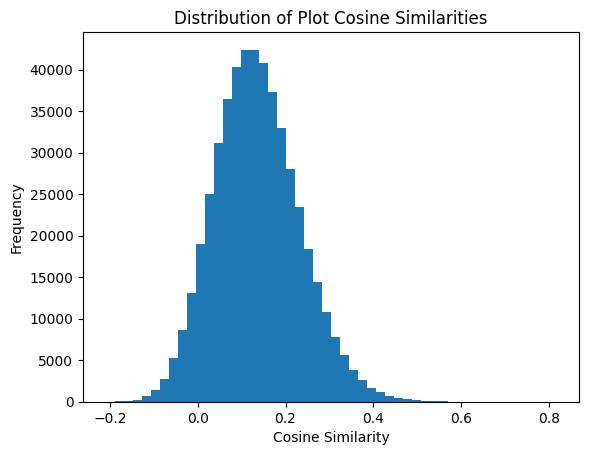

In [31]:
sample_indices = np.random.choice(len(full_plot_embeddings), size=1000, replace=False)
sample_embeddings = full_plot_embeddings[sample_indices]
sim_matrix = cosine_similarity(sample_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1)
sim_scores = sim_matrix[triu_indices]

plt.hist(sim_scores, bins=50)
plt.title("Distribution of Plot Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

The distribution is bell shaped

In [4]:
movies = explore_loader.movies_df

genre_movie_ids = [858, 2571, 8961, 69406, 69458]

genre_movies = movies[movies['movieId'].isin(genre_movie_ids)]
genre_movies

,movieId,title,genres,plot,year
443,858,"Godfather, The (1972)","Crime, Drama",The aging patriarch of an organized crime dyna...,1972
1375,2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller",When a beautiful stranger leads computer hacke...,1999
3660,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
5168,69406,"Proposal, The (2009)","Comedy, Romance",When New York editor Margaret faces deportatio...,2009
5170,69458,Tyson (2008),Documentary,"A mixture of original interviews, archival foo...",2008


In [23]:
def find_most_similar(movie_id, base_embeddings, alt_embeddings, movies_df):
    index = movies_df[movies_df['movieId'] == movie_id].index[0]
    base_embedding = base_embeddings[index]
    alt_embedding = alt_embeddings[index]

    # Compute cosine similarity
    similarities = cosine_similarity([base_embedding], base_embeddings).flatten()

    # Set self-similarity to -1 to ignore it when taking the argmax
    similarities[index] = -1

    nearest_index = np.argmax(similarities)
    similar_movie = movies_df.iloc[nearest_index]
    base_similarity = similarities[nearest_index]

    alt_similarity = cosine_similarity([alt_embedding], [alt_embeddings[nearest_index]])[0][0]

    return similar_movie['movieId'], similar_movie['title'], base_similarity, alt_similarity

def print_similarity_info_genres(movie_ids, genre_embeddings, plot_embeddings, movies_df):
    for movie_id in movie_ids:
        similar_id, similar_title, genre_sim, plot_sim = find_most_similar(
            movie_id, genre_embeddings, plot_embeddings, movies_df
        )
        print(f"{movie_id}\t{similar_id}\t{similar_title[:20]:<20}\tGenreSim: {genre_sim:.4f}\tPlotSim: {plot_sim:.4f}")
        
print_similarity_info_genres(genre_movie_ids, full_genres_embeddings, full_plot_embeddings, explore_loader.movies_df)


858	16	Casino (1995)       	GenreSim: 1.0000	PlotSim: 0.2206
2571	66	Lawnmower Man 2: Bey	GenreSim: 1.0000	PlotSim: 0.3390
8961	26160	Asterix and the Gaul	GenreSim: 1.0000	PlotSim: 0.1613
69406	3	Grumpier Old Men (19	GenreSim: 1.0000	PlotSim: 0.2079
69458	3338	For All Mankind (198	GenreSim: 1.0000	PlotSim: 0.2659
